In [662]:
import yfinance as yf
import pandas as pd
import numpy as np
import plotly 
import plotly.express as px
from matplotlib import pyplot as plt
from finta import TA
import hvplot.pandas
%matplotlib inline
from scipy.stats import norm
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")


In [641]:
#Choose our BTFD ticker, as well as our baseline ticker 'SPY'
btfd_ticker = ['OLLI']
spy_baseline = ['SPY']

In [642]:
#Create 2 dataframes, the 'BTFD ticker' and the SPY baseline
df_btfd = yf.download(btfd_ticker,period='5y')
df_btfd = df_btfd.drop(labels='Adj Close', axis=1)
df_btfd.columns

df_baseline = yf.download(spy_baseline,period='5y')
df_baseline = df_baseline.drop(labels='Adj Close', axis=1)
df_baseline.columns

columns_btfd= ["open", "high", "low", "close", "volume"]
df_btfd.columns = columns_btfd

columns_baseline= ["open", "high", "low", "close", "volume"]
df_baseline.columns = columns_baseline
df_baseline = df_baseline.drop(columns=["open", "high", "low", "volume"])

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [643]:
#Create our dataframes of the ticker EMAs, the ticker close price, and the SPY close
ema_21 = TA.EMA(df_btfd, 21) 
ema_50 = TA.EMA(df_btfd, 50)
ema_200 = TA.EMA(df_btfd, 200)
df_price_close = df_btfd['close']
ema_df = pd.concat([ema_21, ema_50,ema_200,df_price_close, df_baseline], axis="columns", join="inner")

#Rename Columns
columns_ema= ["21EMA", "50EMA", "200EMA", "close","spy_close"]
ema_df.columns = columns_ema
ema_df.head()
ema_df

,21EMA,50EMA,200EMA,close,spy_close
Date,,,,,
2017-03-15,31.750000,31.750000,31.750000,31.750000,238.949997
2017-03-16,32.011905,32.005000,32.001250,32.250000,238.479996
2017-03-17,32.190332,32.176643,32.169165,32.500000,237.029999
2017-03-20,32.236123,32.222616,32.215054,32.349998,236.770004
2017-03-21,32.095561,32.098752,32.099772,31.650000,233.729996
...,...,...,...,...,...
2022-03-08,43.988241,46.826531,62.480911,44.529999,416.250000
2022-03-09,44.027492,46.732158,62.301200,44.419998,427.410004
2022-03-10,43.843174,46.546583,62.099197,42.000000,425.480011


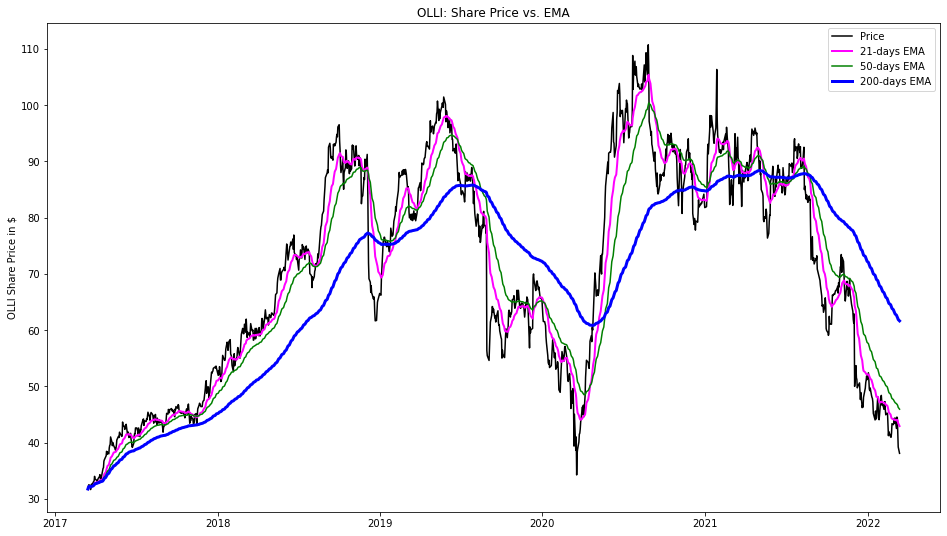

In [756]:
#Plot the EMAs vs. the close

plotted = fig, ax = plt.subplots(figsize=(16,9))

ax.plot(ema_df['close'], label='Price', color='black',linewidth=1.5)
ax.plot(ema_df['21EMA'], label = '21-days EMA', color='magenta',linewidth=2)
ax.plot(ema_df['50EMA'], label = '50-days EMA', color='green')
ax.plot(ema_df['200EMA'], label = '200-days EMA',color='blue',linewidth=3)


ax.legend(loc='best')
ax.title.set_text('OLLI: Share Price vs. EMA')
ax.set_ylabel('OLLI Share Price in $')
plotted 
plt.savefig('OLLI_emas.png')

In [645]:
#Calculate the %away from EMAs

ema_df['%_away_21'] = ((ema_df['close']- ema_df['21EMA'])/((ema_df['close']+ema_df['21EMA'])/2))*100
ema_df['%_away_50'] = ((ema_df['close']- ema_df['50EMA'])/((ema_df['close']+ema_df['50EMA'])/2))*100
ema_df['%_away_200'] = ((ema_df['close']- ema_df['200EMA'])/((ema_df['close']+ema_df['200EMA'])/2))*100

In [764]:
MA_moves = ema_df.drop(columns=["21EMA","50EMA","200EMA","close","spy_close"])

#Plot the distribution of the %away from the different EMAs using Kernal Density
columns=['%_away_21', '%_away_50', '%_away_200']
ema_distribution = MA_moves.hvplot.kde(y=columns, alpha=0.5, value_label='%Away from EMAs', legend='top_left',label='Distribution of %Away from EMA',ylabel='Distribution')
# hvplot.save(ema_distribution,'ema_distribution.png')
ema_distribution

:NdOverlay   [Variable]
   :Distribution   [%Away from EMAs]   (Density)

In [676]:
#Calculate the max and min moves away from the 21EMA
ticker_max = MA_moves['%_away_21'].max(axis=0) 
print(f'The max % away from the 21 EMA is {ticker_max:.2f}')
ticker_min = MA_moves['%_away_21'].min(axis=0) 
print(f'The max % away from the 21 EMA is {ticker_min:.2f}')
ticker_mean = MA_moves['%_away_21'].mean(axis=0) 
print(f'The mean % away from the 21 EMA is {ticker_mean:.2f}')
ticker_median = MA_moves['%_away_21'].median(axis=0) 
print(f'The median % away from the 21 EMA is {ticker_median:.2f}')

The max % away from the 21 EMA is 21.58
The max % away from the 21 EMA is -31.73
The mean % away from the 21 EMA is -0.00
The median % away from the 21 EMA is 0.72


In [766]:
#Plot the max and min moves away from the 21EMA
ticker_21_range = MA_moves[['%_away_21']].hvplot(
    line_color="black",
    line_width=2,
    width=1000,
    height=400
)
ticker_21_range 

:Curve   [Date]   (%_away_21)

# Scale the Data

In [678]:
# Fit the StandardScaler
scaler.fit(MA_moves)

# Scale the data
scaled_data = scaler.transform(MA_moves)

# # Create a DataFrame with the scaled data
MA_scaled = pd.DataFrame(scaled_data)
MA_scaled.index = ema_df.index

#Rename Columns
columns_MA= ["scaled_21EMA", "scaled_50EMA", "scaled_200EMA"]

#This changes all values between 0-1
MA_scaled.columns = columns_MA

scaled_21ema_std = MA_scaled['scaled_21EMA'].std()
print(f'The standard deviation of the scaled distance from the 21ema is {scaled_21ema_std:.2f}, while the 1.5 std.dev is {1.5 * scaled_21ema_std:.2f}')

scaled_50ema_std = MA_scaled['scaled_50EMA'].std()
print(f'The standard deviation of the scaled distance from the 50ema is {scaled_50ema_std:.2f}, while the 1.5 std.dev is {1.5 * scaled_50ema_std:.2f}')

scaled_200ema_std = MA_scaled['scaled_200EMA'].std()
print(f'The standard deviation of the scaled distance from the 200ema is {scaled_200ema_std:.2f}, while the 1.5 std.dev is {1.5 * scaled_200ema_std:.2f}')


The standard deviation of the scaled distance from the 21ema is 0.12, while the 1.5 std.dev is 0.18
The standard deviation of the scaled distance from the 50ema is 0.14, while the 1.5 std.dev is 0.21
The standard deviation of the scaled distance from the 200ema is 0.19, while the 1.5 std.dev is 0.28


In [680]:
#Double check that the dataframe was scaled

ticker_scaled_max = MA_scaled['scaled_21EMA'].max(axis=0) 
print(f'The max % away from the 21 EMA is {ticker_scaled_max}')
ticker_scaled_min = MA_scaled['scaled_21EMA'].min(axis=0) 
print(f'The max % away from the 21 EMA is {ticker_scaled_min}')

The max % away from the 21 EMA is 1.0
The max % away from the 21 EMA is 0.0


# Plot the %_away_21EMA (scaled) vs. the normal distribution

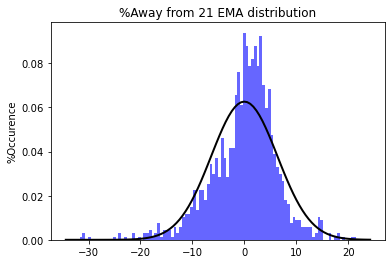

<Figure size 432x288 with 0 Axes>

In [767]:
data = ema_df['%_away_21']
  
# Fit a normal distribution to the data: # mean and standard deviation
mu, std = norm.fit(data) 
  
# Plot the histogram.
plt.hist(data, bins=100, density=True, alpha=0.6, color='b')
  
# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)

plt.plot(x, p, 'k', linewidth=2)
title = "%Away from 21 EMA distribution".format(mu, std)
plt.title('%Away from 21 EMA distribution')
plt.ylabel('%Occurence')
  
plt.show()
plt.savefig('Occurence.png')

In [696]:
#Create a dataframe to capture my signals
ema_df_final = pd.concat([ema_df, MA_scaled], axis="columns", join="inner")
ema_df_final['signal_21']=0
ema_df_final['signal_50']=0
ema_df_final['signal_200']=0
ema_df_final

,21EMA,50EMA,200EMA,close,spy_close,%_away_21,%_away_50,%_away_200,scaled_21EMA,scaled_50EMA,scaled_200EMA,signal_21,signal_50,signal_200
Date,,,,,,,,,,,,,,
2017-03-15,31.750000,31.750000,31.750000,31.750000,238.949997,0.000000,0.000000,0.000000,0.595197,0.564663,0.597420,0,0,0
2017-03-16,32.011905,32.005000,32.001250,32.250000,238.479996,0.741015,0.762587,0.774304,0.609099,0.575218,0.605069,0,0,0
2017-03-17,32.190332,32.176643,32.169165,32.500000,237.029999,0.957385,0.999919,1.023161,0.613158,0.578503,0.607527,0,0,0
2017-03-20,32.236123,32.222616,32.215054,32.349998,236.770004,0.352631,0.394539,0.418011,0.601812,0.570124,0.601549,0,0,0
2017-03-21,32.095561,32.098752,32.099772,31.650000,233.729996,-1.397938,-1.407877,-1.411054,0.568970,0.545177,0.583482,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-08,43.988241,46.826531,62.480911,44.529999,416.250000,1.224058,-5.027627,-33.549687,0.618161,0.495077,0.266012,0,0,0
2022-03-09,44.027492,46.732158,62.301200,44.419998,427.410004,0.887546,-5.073186,-33.510122,0.611848,0.494446,0.266403,0,0,0
2022-03-10,43.843174,46.546583,62.099197,42.000000,425.480011,-4.294283,-10.269358,-38.615470,0.514632,0.422527,0.215972,0,0,0


In [697]:
#Find the price 20 days after the potential signals' daily close price
ema_df_final['close+20']= ema_df_final['close'].shift(-20)
ema_df_final['spy_close+20']= ema_df_final['spy_close'].shift(-20)
ema_df_signal = ema_df_final.copy()
ema_df_signal

,21EMA,50EMA,200EMA,close,spy_close,%_away_21,%_away_50,%_away_200,scaled_21EMA,scaled_50EMA,scaled_200EMA,signal_21,signal_50,signal_200,close+20,spy_close+20
Date,,,,,,,,,,,,,,,,
2017-03-15,31.750000,31.750000,31.750000,31.750000,238.949997,0.000000,0.000000,0.000000,0.595197,0.564663,0.597420,0,0,0,33.700001,234.029999
2017-03-16,32.011905,32.005000,32.001250,32.250000,238.479996,0.741015,0.762587,0.774304,0.609099,0.575218,0.605069,0,0,0,33.299999,232.509995
2017-03-17,32.190332,32.176643,32.169165,32.500000,237.029999,0.957385,0.999919,1.023161,0.613158,0.578503,0.607527,0,0,0,34.900002,234.570007
2017-03-20,32.236123,32.222616,32.215054,32.349998,236.770004,0.352631,0.394539,0.418011,0.601812,0.570124,0.601549,0,0,0,35.400002,233.869995
2017-03-21,32.095561,32.098752,32.099772,31.650000,233.729996,-1.397938,-1.407877,-1.411054,0.568970,0.545177,0.583482,0,0,0,35.549999,233.440002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-08,43.988241,46.826531,62.480911,44.529999,416.250000,1.224058,-5.027627,-33.549687,0.618161,0.495077,0.266012,0,0,0,NaN,NaN
2022-03-09,44.027492,46.732158,62.301200,44.419998,427.410004,0.887546,-5.073186,-33.510122,0.611848,0.494446,0.266403,0,0,0,NaN,NaN
2022-03-10,43.843174,46.546583,62.099197,42.000000,425.480011,-4.294283,-10.269358,-38.615470,0.514632,0.422527,0.215972,0,0,0,NaN,NaN


In [698]:
ema_df_final = ema_df_final.dropna()
ema_df_final

,21EMA,50EMA,200EMA,close,spy_close,%_away_21,%_away_50,%_away_200,scaled_21EMA,scaled_50EMA,scaled_200EMA,signal_21,signal_50,signal_200,close+20,spy_close+20
Date,,,,,,,,,,,,,,,,
2017-03-15,31.750000,31.750000,31.750000,31.750000,238.949997,0.000000,0.000000,0.000000,0.595197,0.564663,0.597420,0,0,0,33.700001,234.029999
2017-03-16,32.011905,32.005000,32.001250,32.250000,238.479996,0.741015,0.762587,0.774304,0.609099,0.575218,0.605069,0,0,0,33.299999,232.509995
2017-03-17,32.190332,32.176643,32.169165,32.500000,237.029999,0.957385,0.999919,1.023161,0.613158,0.578503,0.607527,0,0,0,34.900002,234.570007
2017-03-20,32.236123,32.222616,32.215054,32.349998,236.770004,0.352631,0.394539,0.418011,0.601812,0.570124,0.601549,0,0,0,35.400002,233.869995
2017-03-21,32.095561,32.098752,32.099772,31.650000,233.729996,-1.397938,-1.407877,-1.411054,0.568970,0.545177,0.583482,0,0,0,35.549999,233.440002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-07,47.071248,50.849013,66.651456,45.919998,447.260010,-2.476039,-10.187176,-36.832531,0.548744,0.423664,0.233584,0,0,0,44.529999,416.250000
2022-02-08,46.996589,50.668659,66.448456,46.250000,450.940002,-1.601322,-9.118284,-35.845133,0.565155,0.438458,0.243338,0,0,0,44.419998,427.410004
2022-02-09,47.022353,50.535771,66.257724,47.279999,457.540009,0.546424,-6.656947,-33.429815,0.605448,0.472526,0.267196,0,0,0,42.000000,425.480011


In [702]:
# Generate the trading signal 1 or 0,
percentile_21 = 0.13 #or 1.5σ which represents about 87%
percentile_50 = 0.13 #or 1.5σ which represents about 87%
percentile_200 = 0.13 #or 1.5σ which represents about 87%


In [713]:
#Find out when you are getting the signals across the board 
#in the 21, 50, 200 emas....

ema_df_signal["signal_21"]= np.where(
    ema_df_signal["scaled_21EMA"] < percentile_21, 1.0, 0.0
)

ema_df_signal["signal_50"]= np.where(
    ema_df_signal["scaled_50EMA"] < percentile_50, 1.0, 0.0
)

ema_df_signal["signal_200"]= np.where(
    ema_df_signal["scaled_200EMA"] < percentile_200, 1.0, 0.0
)

ema_df_signal


,21EMA,50EMA,200EMA,close,spy_close,%_away_21,%_away_50,%_away_200,scaled_21EMA,scaled_50EMA,scaled_200EMA,signal_21,signal_50,signal_200,close+20,spy_close+20
Date,,,,,,,,,,,,,,,,
2017-03-15,31.750000,31.750000,31.750000,31.750000,238.949997,0.000000,0.000000,0.000000,0.595197,0.564663,0.597420,0.0,0.0,0.0,33.700001,234.029999
2017-03-16,32.011905,32.005000,32.001250,32.250000,238.479996,0.741015,0.762587,0.774304,0.609099,0.575218,0.605069,0.0,0.0,0.0,33.299999,232.509995
2017-03-17,32.190332,32.176643,32.169165,32.500000,237.029999,0.957385,0.999919,1.023161,0.613158,0.578503,0.607527,0.0,0.0,0.0,34.900002,234.570007
2017-03-20,32.236123,32.222616,32.215054,32.349998,236.770004,0.352631,0.394539,0.418011,0.601812,0.570124,0.601549,0.0,0.0,0.0,35.400002,233.869995
2017-03-21,32.095561,32.098752,32.099772,31.650000,233.729996,-1.397938,-1.407877,-1.411054,0.568970,0.545177,0.583482,0.0,0.0,0.0,35.549999,233.440002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-08,43.988241,46.826531,62.480911,44.529999,416.250000,1.224058,-5.027627,-33.549687,0.618161,0.495077,0.266012,0.0,0.0,0.0,NaN,NaN
2022-03-09,44.027492,46.732158,62.301200,44.419998,427.410004,0.887546,-5.073186,-33.510122,0.611848,0.494446,0.266403,0.0,0.0,0.0,NaN,NaN
2022-03-10,43.843174,46.546583,62.099197,42.000000,425.480011,-4.294283,-10.269358,-38.615470,0.514632,0.422527,0.215972,0.0,0.0,0.0,NaN,NaN


In [715]:
#Calculate when we get our signals for the 21, 50, 200 EMAs
ema_df_21signal = ema_df_signal.loc[(ema_df_signal['signal_21']==1.0),:]
ema_df_21signal_bt =ema_df_21signal.dropna()

ema_df_50signal = ema_df_signal.loc[(ema_df_signal['signal_50']==1.0),:]
ema_df_50signal_bt = ema_df_50signal.dropna()

ema_df_200signal = ema_df_signal.loc[(ema_df_signal['signal_200']==1.0),:]
ema_df_200signal_bt = ema_df_200signal.dropna()

#Preview the df
ema_df_21signal_bt 


,21EMA,50EMA,200EMA,close,spy_close,%_away_21,%_away_50,%_away_200,scaled_21EMA,scaled_50EMA,scaled_200EMA,signal_21,signal_50,signal_200,close+20,spy_close+20
Date,,,,,,,,,,,,,,,,
2019-08-29,77.611577,82.153317,84.178509,56.360001,292.579987,-31.725500,-37.243085,-39.588450,0.000000,0.049187,0.206361,1.0,1.0,0.0,59.860001,295.399994
2019-08-30,75.596888,81.106128,83.892078,55.450001,292.450012,-30.747601,-37.575944,-40.823386,0.018346,0.044580,0.194162,1.0,1.0,0.0,58.639999,296.769989
2019-09-03,73.688080,80.066672,83.600033,54.599998,290.739990,-29.758153,-37.821791,-41.968203,0.036909,0.041177,0.182853,1.0,1.0,0.0,58.400002,293.239990
2020-03-18,46.737442,51.803558,63.943201,34.250000,240.000000,-30.837971,-40.796822,-60.479138,0.016651,0.000000,0.000000,1.0,1.0,1.0,55.029999,279.100006
2021-12-03,64.343020,67.087993,76.942768,49.990002,453.420013,-25.107389,-29.207865,-42.467783,0.124161,0.160401,0.177918,1.0,0.0,0.0,52.410000,477.709991


# Plot the signals

In [777]:
# Visualize entry position of the signals


price_plot = ema_df_final[["close"]].hvplot(
    color='black',
    line_width=2,
    title = "21 EMA Extreme Move Signal vs. EMAs / Close Price",
    width=1000,
    height=400
)

signal_21 = ema_df_21signal_bt[ema_df_21signal_bt["signal_21"] == 1.0]["close"].hvplot.scatter(
    color="magenta",
    marker="^",
    size=300,
    legend=False,
    ylabel="Price in $",
    width=1000,
    height=400
)

ema_21_plot = ema_df_final[["21EMA"]].hvplot(
    color='magenta',
    line_width=2,
    width=1000,
    height=400
)

signal_50 = ema_df_50signal_bt[ema_df_50signal_bt["signal_50"] == 1.0]["close"].hvplot.scatter(
    color="green",
    marker="x",
    size=500,
    legend=False,
    ylabel="Price in $",
    width=1000,
    height=400
)

ema_50_plot = ema_df_final[["50EMA"]].hvplot(
    line_color="green",
    width=1000,
    height=400
)

signal_200 = ema_df_200signal_bt[ema_df_200signal_bt["signal_200"] == 1.0]["close"].hvplot.scatter(
    color="blue",
    marker=">",
    size=200,
    legend=False,
    ylabel="Price in $",
    width=1000,
    height=400
)

ema_200_plot = ema_df_final[["200EMA"]].hvplot(
    line_color="blue",
    line_width=3,
    width=1000,
    height=400
)

ema_signals_plot = price_plot * signal_21 * ema_21_plot * signal_50 * ema_50_plot * signal_200 * ema_200_plot
hvplot.save(ema_signals_plot,'ema_signals_plot.html')
ema_signals_plot


:Overlay
   .Curve.I           :Curve   [Date]   (close)
   .Scatter.Close.I   :Scatter   [Date]   (close)
   .Curve.II          :Curve   [Date]   (21EMA)
   .Scatter.Close.II  :Scatter   [Date]   (close)
   .Curve.III         :Curve   [Date]   (50EMA)
   .Scatter.Close.III :Scatter   [Date]   (close)
   .Curve.IV          :Curve   [Date]   (200EMA)

## Whats the average % difference when we get this 21EMA signal to the price 4 weeks after?

In [741]:
#Calculate for the 21EMA
ema_df_21signal_bt['20day_%_diff']= ((ema_df_21signal_bt['close+20']- ema_df_21signal_bt['close'])/((ema_df_21signal_bt['close+20']+ema_df_21signal_bt['close'])/2))*100
mean1 = ema_df_21signal_bt['20day_%_diff'].mean()
print(f'The ave. % diff of OLLI  20 trading days after our 21EMA signal is {mean1:.2f}')

ema_df_21signal_bt['spy_20day_%_diff']= ((ema_df_21signal_bt['spy_close+20']- ema_df_21signal_bt['spy_close'])/((ema_df_21signal_bt['spy_close+20']+ema_df_21signal_bt['spy_close'])/2))*100
mean4 = ema_df_21signal_bt['spy_20day_%_diff'].mean()
print(f'The ave. % diff in the SPY 20 trading days after our 21EMA signal is {mean4:.2f}')


# Calculate for the 50EMA

ema_df_50signal_bt['20day_%_diff']= ((ema_df_50signal_bt['close+20']- ema_df_50signal_bt['close'])/((ema_df_50signal_bt['close+20']+ema_df_50signal_bt['close'])/2))*100
mean2 = ema_df_50signal_bt['20day_%_diff'].mean()
print(f'The ave. % diff of OLLI 20 trading days after our 50EMA signal is {mean2:.2f}')

ema_df_50signal_bt['spy_20day_%_diff']= ((ema_df_50signal_bt['spy_close+20']- ema_df_50signal_bt['spy_close'])/((ema_df_50signal_bt['spy_close+20']+ema_df_50signal_bt['spy_close'])/2))*100
mean5 = ema_df_50signal_bt['spy_20day_%_diff'].mean()
print(f'The ave. % diff in the SPY 20 trading days after our 50EMA signal is {mean5:.2f}')

#Calculate for the 200EMA

ema_df_200signal_bt['20day_%_diff']= ((ema_df_200signal_bt['close+20']- ema_df_200signal_bt['close'])/((ema_df_200signal_bt['close+20']+ema_df_200signal_bt['close'])/2))*100
mean3 = ema_df_200signal_bt['20day_%_diff'].mean()
print(f'The ave. % diff of OLLI 20 trading days after our 200EMA signal is {mean3:.2f}')

ema_df_200signal_bt['spy_20day_%_diff']= ((ema_df_200signal_bt['spy_close+20']- ema_df_200signal_bt['spy_close'])/((ema_df_200signal_bt['spy_close+20']+ema_df_200signal_bt['spy_close'])/2))*100
mean6 = ema_df_200signal_bt['spy_20day_%_diff'].mean()
print(f'The ave. % diff in the SPY 20 trading days after our 200EMA signal is {mean6:.2f}')


The ave. % diff of OLLI  20 trading days after our 21EMA signal is 13.92
The ave. % diff in the SPY 20 trading days after our 21EMA signal is 4.71
The ave. % diff of OLLI 20 trading days after our 50EMA signal is 12.34
The ave. % diff in the SPY 20 trading days after our 50EMA signal is 3.26
The ave. % diff of OLLI 20 trading days after our 200EMA signal is 38.86
The ave. % diff in the SPY 20 trading days after our 200EMA signal is 16.29


In [742]:
#Now that we've generated our signals, lets' visualize the difference in returns
diff_returns = ema_df_signal.filter(['close', 'spy_close'])
diff_returns['ticker_return']= diff_returns['close'].pct_change()
diff_returns['spy_return']= diff_returns['spy_close'].pct_change()
diff_returns['cum_ticker_return'] = diff_returns['ticker_return'].cumsum()
diff_returns['cum_spy_return'] = diff_returns['spy_return'].cumsum()
diff_returns = diff_returns.filter(['cum_ticker_return', 'cum_spy_return'])
diff_returns = diff_returns.dropna()
diff_returns

,cum_ticker_return,cum_spy_return
Date,,
2017-03-16,0.015748,-0.001967
2017-03-17,0.023500,-0.008047
2017-03-20,0.018885,-0.009144
2017-03-21,-0.002754,-0.021983
2017-03-22,0.014624,-0.019630
...,...,...
2022-03-08,0.846903,0.648956
2022-03-09,0.844432,0.675767
2022-03-10,0.789952,0.671252


In [743]:
#Plot the cumulative returns

cum_ticker_return = diff_returns[['cum_ticker_return']].hvplot(
    line_color="black",
    ylabel="Total % Return",
    line_width=3,
    width=1000,
    height=400
)

spy_returns = diff_returns[['cum_spy_return']].hvplot(
    line_color="red",
    line_width=2,
    width=1000,
    height=400
)

cum_returns = cum_ticker_return * spy_returns 
cum_returns


:Overlay
   .Curve.I  :Curve   [Date]   (cum_ticker_return)
   .Curve.II :Curve   [Date]   (cum_spy_return)

In [776]:
#Plot the difference in performance

table = ema_df_21signal_bt.filter(['20day_%_diff','spy_20day_%_diff'])

spy_vs_olli = table.hvplot.bar(stacked=False,rot = 60,  height=500, legend='top_left', title="%Difference SPY vs. OLLI 20 days after signal", ylabel="%Return 20 days after signal")
hvplot.save(spy_vs_olli,'spy_vs_olli.html')
spy_vs_olli 

:Bars   [Date,Variable]   (value)

# Now let's try linear regression

In [745]:
#Try Linear Regression using the %away from 50 and 200 EMAs as features
df_lr_target = ema_df_final[["close","%_away_21","%_away_50","%_away_200","close+20"]]
df_lr_target["close_20return"] = ((df_lr_target['close+20']- df_lr_target['close'])/((df_lr_target['close+20']+df_lr_target['close'])/2))*100
df_lr_target.index = df_lr_target["%_away_21"]
df_lr_target

,close,%_away_21,%_away_50,%_away_200,close+20,close_20return
%_away_21,,,,,,
0.000000,31.750000,0.000000,0.000000,0.000000,33.700001,5.958749
0.741015,32.250000,0.741015,0.762587,0.774304,33.299999,3.203659
0.957385,32.500000,0.957385,0.999919,1.023161,34.900002,7.121666
0.352631,32.349998,0.352631,0.394539,0.418011,35.400002,9.003699
-1.397938,31.650000,-1.397938,-1.407877,-1.411054,35.549999,11.607142
...,...,...,...,...,...,...
-2.476039,45.919998,-2.476039,-10.187176,-36.832531,44.529999,-3.073520
-1.601322,46.250000,-1.601322,-9.118284,-35.845133,44.419998,-4.036620
0.546424,47.279999,0.546424,-6.656947,-33.429815,42.000000,-11.827954


In [746]:
df_lr_target = df_lr_target.drop(columns=["close", "%_away_21", "close+20"])
df_lr_target.head(15)

,%_away_50,%_away_200,close_20return
%_away_21,,,
0.000000,0.000000,0.000000,5.958749
0.741015,0.762587,0.774304,3.203659
0.957385,0.999919,1.023161,7.121666
0.352631,0.394539,0.418011,9.003699
-1.397938,-1.407877,-1.411054,11.607142
0.256973,0.256984,0.258420,13.062409
1.211320,1.250557,1.271839,12.508993
0.621928,0.675981,0.705388,14.438883
1.808324,1.916250,1.973520,13.314449


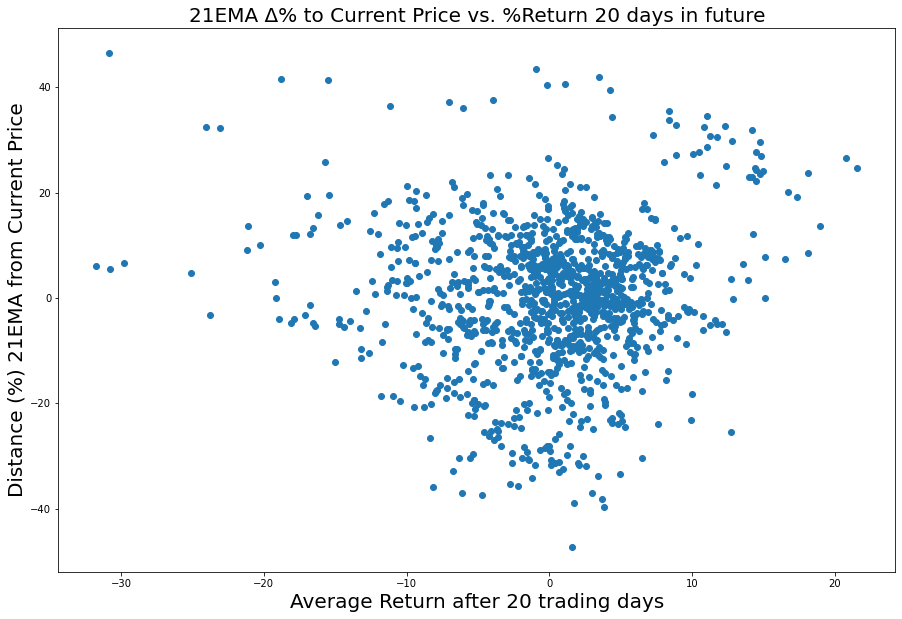

<Figure size 432x288 with 0 Axes>

In [747]:
# # Create a scatter plot of the data
plt.figure(figsize=(15,10))
plt.scatter(df_lr_target.index,df_lr_target.close_20return)
plt.title("21EMA Δ% to Current Price vs. %Return 20 days in future",fontsize=20)
plt.xlabel("Average Return after 20 trading days",fontsize=20)
plt.ylabel("Distance (%) 21EMA from Current Price",fontsize=20)
plt.show()
plt.savefig('pic.png')
#X-axis the return 20 days in the future

In [748]:
# Create a Linear Regression Model using sklearn
from sklearn.linear_model import LinearRegression
model = LinearRegression()
df = df_lr_target

In [749]:
# Separate the data into the X and y components
# In this case, y will be the `%percentile occurence` and X will be the remaining columns
X = df.index.values.reshape(-1,1)
y = df['close_20return']

In [750]:
# Fit the model to the data
model.fit(X, y)

LinearRegression()

In [751]:
# # Make predictions using the X data
predicted_y_values = model.predict(X)
predicted_y_values

array([ 0.40889487,  0.49167484,  0.51584582, ...,  0.46993674,
        0.15886344, -0.02943835])

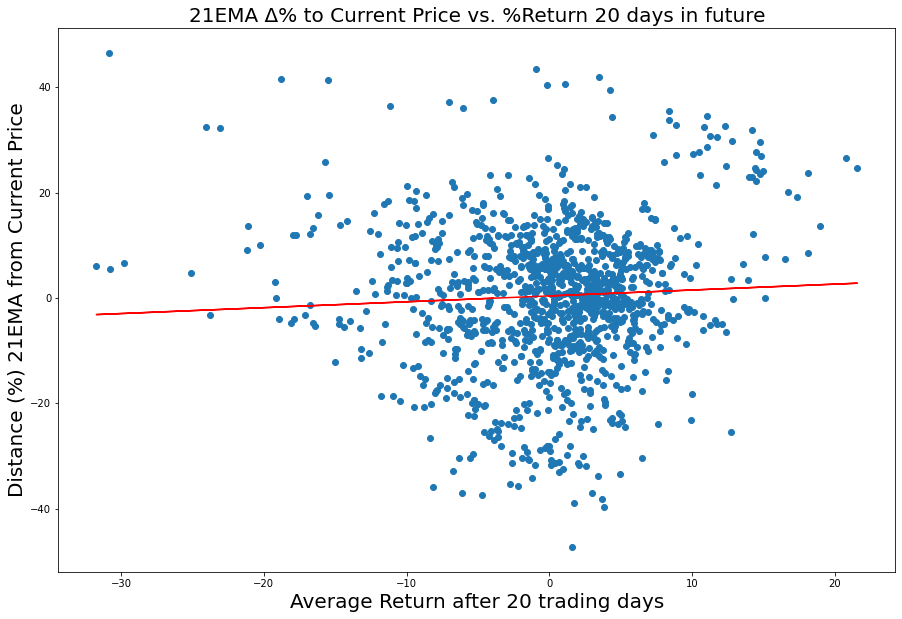

<Figure size 432x288 with 0 Axes>

In [779]:
# Plot X and y as a scatter plot
# Plot X and the predictions as a red line plot
plt.figure(figsize=(15,10))
plt.scatter(X, y)
plt.plot(X, predicted_y_values, color='red')
plt.title("21EMA Δ% to Current Price vs. %Return 20 days in future",fontsize=20)
plt.xlabel("Average Return after 20 trading days",fontsize=20)
plt.ylabel("Distance (%) 21EMA from Current Price",fontsize=20)
plt.show()

from matplotlib import pyplot as plt

plt.savefig('21EMA.png')

In [753]:
# # Display the coefficient
model.coef_

array([0.11171157])

In [754]:
# # Display the intercept
model.intercept_


0.40889486973603195

In [755]:
# # R2 value
model.score(X, y, sample_weight=None)

0.002911431601022474